## CV классификация изображений 10-и пород собак на основе данных imagenette
с применением фреймворка Albumentations и предобученной нейросети resnet18

In [1]:
# Датасет:  https://github.com/fastai/imagenette, подраздел Imagewoof

In [2]:
import albumentations as A

In [3]:
import pandas as pd
import numpy as np
from IPython.display import display

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torchvision import datasets

import matplotlib.pyplot as plt
import seaborn as sns
import os
from PIL import Image

In [4]:
# Проанализируем и подготовим данные
df = pd.read_csv('C:/Users/vyugo/Documents/!Python/!Выполненные проекты/CV/!Сбербанк/imagewoof2-320/noisy_imagewoof.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12954 entries, 0 to 12953
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   path             12954 non-null  object
 1   noisy_labels_0   12954 non-null  object
 2   noisy_labels_1   12954 non-null  object
 3   noisy_labels_5   12954 non-null  object
 4   noisy_labels_25  12954 non-null  object
 5   noisy_labels_50  12954 non-null  object
 6   is_valid         12954 non-null  bool  
dtypes: bool(1), object(6)
memory usage: 620.0+ KB


In [5]:
# Выделим из общей таблицы необходимые данные
df = pd.DataFrame(df, columns=['path', 'noisy_labels_0', 'is_valid'])

# Посмотрим как распределены классы
df['noisy_labels_0'].value_counts()

n02093754    1350
n02111889    1350
n02086240    1350
n02105641    1350
n02096294    1350
n02099601    1350
n02088364    1350
n02115641    1350
n02087394    1350
n02089973     804
Name: noisy_labels_0, dtype: int64

In [6]:
# Переименуем классы в соответствиями с требованиями Resnet
newclass = {
    'n02088364': 0,
    'n02111889': 1,
    'n02105641': 2,
    'n02093754': 3,
    'n02086240': 4,
    'n02096294': 5,
    'n02087394': 6,
    'n02099601': 7,
    'n02115641': 8,
    'n02089973': 9}

df['noisy_labels_0'] = df['noisy_labels_0'].replace(newclass)

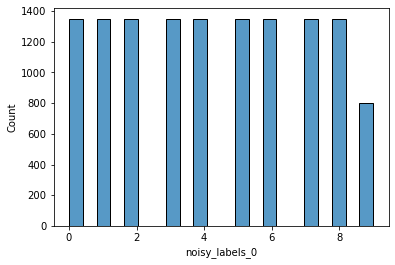

In [7]:
# Рассмотрим равномерномерность распределения по классам на графике 
sns_plot = sns.histplot(df['noisy_labels_0'])
fig = sns_plot

In [8]:
# Путь к директории с фотографиями
img_dir = 'C:/Users/vyugo/Documents/!Python/!Выполненные проекты/CV/!Сбербанк/imagewoof2-320/'

# Выделим обучающий и валидационный датасеты по столбцу is_valid
df_train = df[df['is_valid'] == False]
df_valid = df[df['is_valid'] == True]

display(df.tail())

# Проверим размеры обучающей и валидационной выборки
print('Размер обучающей выборки = ', df_train.shape)
print('Размер валидационной выборки = ', df_valid.shape)

,path,noisy_labels_0,is_valid
12949,val/n02089973/n02089973_9351.JPEG,9,True
12950,val/n02089973/n02089973_1241.JPEG,9,True
12951,val/n02089973/n02089973_4702.JPEG,9,True
12952,val/n02089973/n02089973_1040.JPEG,9,True
12953,val/n02089973/n02089973_9591.JPEG,9,True


Размер обучающей выборки =  (9025, 3)
Размер валидационной выборки =  (3929, 3)


In [9]:
# Параметры аугментации для тренировочных данных
train_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.HorizontalFlip(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)

In [10]:
# Для валидации
val_transform = A.Compose(
    [
        A.Resize(224, 224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
    ]
)

In [11]:
# Подготовим датасет с изображениями при помощи фреймворка albumentations
class AlbumentationImageDataset(Dataset):
    def __init__(self, annotations_file, img_dir, aug=None):
        self.img_labels = annotations_file
        self.img_dir = img_dir
        self.aug = aug

    def __len__(self):
        return (len(self.img_labels))
    
    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        image = plt.imread(img_path)
        image = Image.fromarray(image).convert('RGB')
        image = self.aug(image=np.array(image))['image']
        image = np.transpose(image, (2, 0, 1)).astype(np.float32)
        image = torch.tensor(image, dtype=torch.float)
        label = self.img_labels.iloc[idx, 1]
        sample = (image, label)
        return sample            

In [12]:
train_set = AlbumentationImageDataset(annotations_file = df_train, img_dir = img_dir, aug = train_transform)
test_set = AlbumentationImageDataset(annotations_file = df_valid, img_dir = img_dir, aug = val_transform)

In [13]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=72, shuffle=True, num_workers=0)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=56, shuffle=False, num_workers=0)

In [14]:
class PixelRegressionDataset(torch.utils.data.Dataset):
    def __init__(self, donor_dataset):
        self.donor_dataset = donor_dataset

    def __len__(self):
        return len(self.donor_dataset)

    def __getitem__(self, idx):
        img_tensor, object_label = self.donor_dataset[idx]
        channels, h, w = img_tensor.size()
        x = np.random.randint(w)
        y = np.random.randint(h)
        img_tensor[1:2, y, x] = -1
        return {'image': img_tensor, 'xy': torch.FloatTensor([x, y]), 'label': object_label}

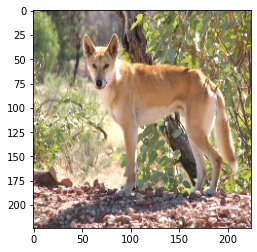

In [15]:
def show_image(img_tensor):
    image = np.moveaxis(img_tensor.numpy(), 0, 2)
    image = image * np.array([0.229, 0.224, 0.225]) + np.array([0.485, 0.456, 0.406])
    plt.imshow(image)

show_image(next(iter(PixelRegressionDataset(train_set)))['image'])

In [16]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

from torchvision.models import resnet18
net = resnet18(pretrained=True)
net.fc = torch.nn.Linear(in_features=512, out_features=10, bias=True)
net = net.to(device)

In [17]:
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.0001)

In [18]:
for epoch in range(5):

    net.train()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in train_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        predictions = net(images)
        correct += (labels == predictions.argmax(dim=1)).sum()
        total += len(labels)

        loss = loss_function(predictions, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    print(f'Train: {epoch_loss / len(train_loader)} | acc: {correct / total}')

    net.eval()
    epoch_loss = 0.
    correct = 0
    total = 0

    for batch in test_loader:
        images, labels = batch
        images = images.to(device)
        labels = labels.to(device)

        predictions = net(images)

        correct += (labels == predictions.argmax(dim=1)).sum()
        total += len(labels)

        with torch.no_grad():
            loss = loss_function(predictions, labels)

        epoch_loss += loss.item()
    print(f'Test: {epoch_loss / len(test_loader)} | acc: {correct / total}')

Train: 0.5151189718218077 | acc: 0.8479778170585632
Test: 0.30432450078742607 | acc: 0.902519702911377
Train: 0.21828616756413663 | acc: 0.9305263161659241
Test: 0.277880349576893 | acc: 0.907355546951294
Train: 0.14575283802927486 | acc: 0.9575623273849487
Test: 0.2879391035957026 | acc: 0.9083735942840576
Train: 0.10085154077895576 | acc: 0.9719667434692383
Test: 0.2795084089460507 | acc: 0.9093917012214661
Train: 0.08123203850395623 | acc: 0.9755124449729919
Test: 0.28383759485269094 | acc: 0.9093917012214661


### Вывод:
Size(px) = 224, Epochs = 5, Accuracy mean = 90.74%